In [5]:
import pybedtools as pbt
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import treeswift as ts
from Bio import SeqIO, Seq, motifs
import re
import logomaker
from collections import defaultdict
import numpy as np
from os.path import exists

In [11]:
taxdict = {}
taxonomy_tree = ts.read_tree_newick('../data/metazoan_taxonomy.nwk')
tax_groups = ['Ctenophora', 
             'Hemichordata', 
             'Bryozoa', 
             'Rotifera', 
             'Chordata', 
             'Echinodermata', 
             'Arthropoda', 
             'Mollusca', 
             'Annelida', 
             'Nematoda', 
             'Platyhelminthes',
             'Cnidaria']

for tax in tax_groups:
    for node in taxonomy_tree.root.traverse_bfs():
        if node[0].label.strip("'") == tax:
            for i in node[0].traverse_leaves():
                taxdict[i.label.strip("'").replace(' ', '_')] = tax 
                

metadata_df = pd.read_csv('../data/parsed_metazoans.out', 
                          sep='\t', 
                          header=None, 
                          names=['species', 'genome', 'ftpdir', 'scaffold_n50', 'assembly_status']) \
                .drop(['ftpdir', 'genome'], axis=1)
metadata_df['genus'] = metadata_df['species'].apply(lambda x: x.split('_')[0])
metadata_df['taxonomy'] = metadata_df.species.apply(lambda x: taxdict.get(x, 'Other'))
print(metadata_df.head())

                 species  scaffold_n50 assembly_status         genus  \
0     Abisara_bifasciata           464          Contig       Abisara   
1   Abrostola_tripartita      13645312      Chromosome     Abrostola   
2  Abscondita_terminalis       1220005        Scaffold    Abscondita   
3     Acanthaster_planci       1521119        Scaffold   Acanthaster   
4   Acanthisitta_chloris         64469        Scaffold  Acanthisitta   

        taxonomy  
0          Other  
1     Arthropoda  
2     Arthropoda  
3  Echinodermata  
4       Chordata  


In [39]:
def extract_znf(species):
    znfs = []
    for record in SeqIO.parse(f'../data/seqs/{species}_znfs.fa', 'fasta'):
        seq = record.seq
        trim = len(seq)%3
        if trim == 0: 
            seq = str(seq.translate())
        else:
            seq = str(seq[:-trim].translate())        
        znfs += re.findall('C..C.{12}H...H', seq)
    return znfs

def extract_footprints(species):
    footprints = []
    for record in SeqIO.parse(f'../data/seqs/{species}_znfs.fa', 'fasta'):
        seq = record.seq
        trim = len(seq)%3
        if trim == 0: 
            seq = str(seq.translate())
        else:
            seq = str(seq[:-trim].translate())
        footprints += re.findall('C..C.{12}H...H', seq)
    footprints = [f'{i[9]}{i[11]}{i[12]}{i[15]}' for i in footprints]
    return footprints

def entropy(position):
    return -sum(position.apply(lambda x: x*np.log2(x)))

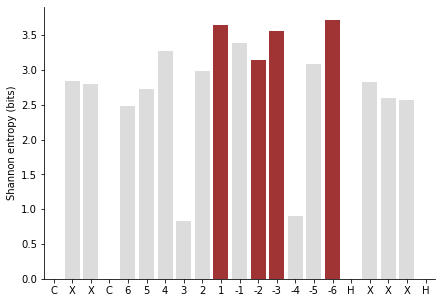

In [40]:
znfs = []
for row in metadata_df.loc[metadata_df.taxonomy == 'Mollusca'].iterrows():
    if row[1].scaffold_n50 >= 10000:
        znfs += extract_znf(row[1].species)
mat_df = logomaker.alignment_to_matrix(znfs, to_type='probability').T
data = defaultdict(list)
for col in mat_df.columns:
    data['position'].append(col)
    data['entropy'].append(entropy(mat_df[col]))
    
znf_df = pd.DataFrame(data)
znf_df['pos_labels'] = ['C', 'X', 'X', 'C', 6, 5, 4, 3, 2, 1, -1, -2, -3, -4, -5, -6, 'H', 'X', 'X', 'X', 'H']
znf_df['colours'] = ['deepskyblue', 'gainsboro', 'gainsboro', 'deepskyblue', 
                     'gainsboro', 'gainsboro', 'gainsboro', 'gainsboro', 'gainsboro', 'firebrick',
                     'gainsboro', 'firebrick', 'firebrick', 'gainsboro', 'gainsboro', 'firebrick',
                     'mediumturquoise', 'gainsboro', 'gainsboro', 'gainsboro', 'mediumturquoise'] 

fig, ax = plt.subplots(figsize=(7, 5))
sns.barplot(data=znf_df, x='position', y='entropy', palette=znf_df.colours)
ax.set_xlabel('')
ax.set_ylabel('Shannon entropy (bits)')
ax.set_xticklabels(znf_df.pos_labels)
sns.despine()
plt.show()


In [41]:
fp_freq = defaultdict(int)
all_fps = extract_footprints('Danio_rerio')
for fp in all_fps:
    fp_freq[fp] += 1
print(fp_freq)

defaultdict(<class 'int'>, {'RAAG': 1, 'NAER': 2, 'TNKE': 1, 'HFVR': 1, 'QGTL': 3, 'QSSR': 46, 'DSNK': 7, 'QSNT': 4, 'RCDA': 1, 'YFEV': 1, 'RSNQ': 74, 'RTNV': 2, 'QCNV': 1, 'RWNL': 1, 'RDIV': 1, 'RDHS': 3, 'NSAN': 2, 'SRGR': 1, 'YFTK': 1, 'AADT': 1, 'HVAM': 1, 'DGNR': 4, 'AQKT': 1, 'QGQT': 1, 'SQSS': 1, 'QGYR': 2, 'VQSS': 4, 'AQCS': 1, 'HQSR': 1, 'VQNS': 1, 'VHKY': 1, 'LNHR': 1, 'MQSS': 1, 'LQST': 1, 'VQNV': 2, 'QGQR': 1, 'EHNI': 1, 'KGNK': 1, 'TKEV': 1, 'SGNT': 2, 'TQSV': 1, 'DSHT': 1, 'QICS': 1, 'QAHR': 3, 'DAHV': 1, 'QTNK': 1, 'RDVI': 1, 'YGGT': 1, 'CSYI': 5, 'TQEL': 4, 'LNQV': 2, 'TGNA': 20, 'HPHN': 1, 'NTSS': 1, 'QSAS': 8, 'IAQY': 1, 'KGIN': 1, 'RDVT': 5, 'YGSS': 7, 'SRDV': 1, 'TEEL': 4, 'TSSI': 2, 'TANV': 3, 'HSQN': 1, 'KGTS': 2, 'YPST': 1, 'TKQY': 1, 'QGIN': 1, 'YSYN': 2, 'TNSS': 2, 'MANV': 1, 'TTEC': 1, 'KTIN': 1, 'LKEV': 1, 'TASV': 1, 'TTAY': 1, 'KAIN': 1, 'RGVT': 1, 'YSFA': 1, 'TKER': 1, 'LWQA': 1, 'HSHK': 19, 'TSSS': 2, 'TTHA': 1, 'KIIN': 1, 'SSKI': 106, 'TYNR': 1, 'EYLA': 1